In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Загрузка данных STL10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Определение архитектуры нейронной сети
class RecurrentNet(nn.Module):
    def __init__(self):
        super(RecurrentNet, self).__init__()
        self.rnn = nn.RNN(input_size=3*96*96, hidden_size=256, num_layers=2, nonlinearity='relu')
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 классов в STL10

    def forward(self, x):
        x = x.view(-1, 3*96*96)  # Преобразование изображения в одномерный вектор
        out, _ = self.rnn(x.unsqueeze(0))
        out = out[-1, :]  # Используем только последний выходной слой
        out = self.fc1(out)
        out = torch.nn.functional.elu(out)  # Функция активации ELU
        out = self.fc2(out)
        return out

# Инициализация модели, функции потерь и оптимизатора
model = RecurrentNet()
criterion = nn.KLDivLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 10
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = torch.nn.functional.softmax(model(images), dim=1)  # Применяем softmax для получения вероятностей
        loss = criterion(torch.log(outputs), outputs)  # Приведение к ожидаемому формату для KLDivLoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

print("Обучение завершено!")


Files already downloaded and verified
Epoch [1/10], Step [10/79], Loss: 0.0000
Epoch [1/10], Step [20/79], Loss: 0.0000
Epoch [1/10], Step [30/79], Loss: -0.0000
Epoch [1/10], Step [40/79], Loss: 0.0000
Epoch [1/10], Step [50/79], Loss: 0.0000
Epoch [1/10], Step [60/79], Loss: 0.0000
Epoch [1/10], Step [70/79], Loss: 0.0000
Epoch [2/10], Step [10/79], Loss: 0.0000
Epoch [2/10], Step [20/79], Loss: 0.0000
Epoch [2/10], Step [30/79], Loss: 0.0000
Epoch [2/10], Step [40/79], Loss: 0.0000
Epoch [2/10], Step [50/79], Loss: 0.0000
Epoch [2/10], Step [60/79], Loss: 0.0000
Epoch [2/10], Step [70/79], Loss: 0.0000
Epoch [3/10], Step [10/79], Loss: 0.0000
Epoch [3/10], Step [20/79], Loss: 0.0000
Epoch [3/10], Step [30/79], Loss: 0.0000
Epoch [3/10], Step [40/79], Loss: 0.0000
Epoch [3/10], Step [50/79], Loss: 0.0000
Epoch [3/10], Step [60/79], Loss: 0.0000
Epoch [3/10], Step [70/79], Loss: 0.0000
Epoch [4/10], Step [10/79], Loss: 0.0000
Epoch [4/10], Step [20/79], Loss: 0.0000
Epoch [4/10], Step

Epoch [1/10], Average Loss: 0.0000
Epoch [2/10], Average Loss: 0.0000
Epoch [3/10], Average Loss: 0.0000
Epoch [4/10], Average Loss: 0.0000
Epoch [5/10], Average Loss: 0.0000
Epoch [6/10], Average Loss: 0.0000
Epoch [7/10], Average Loss: 0.0000
Epoch [8/10], Average Loss: 0.0000
Epoch [9/10], Average Loss: 0.0000
Epoch [10/10], Average Loss: 0.0000


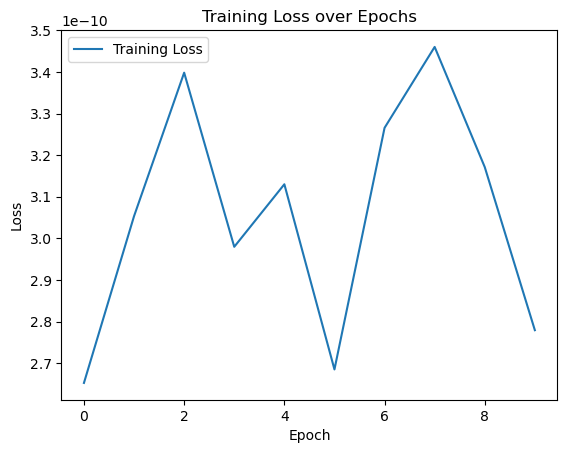

In [16]:
import matplotlib.pyplot as plt

# Список для сохранения потерь на каждой эпохе
losses = []

# Обучение модели
num_epochs = 10
total_step = len(trainloader)
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Потери для текущей эпохи
    for i, (images, labels) in enumerate(trainloader):
        outputs = torch.nn.functional.softmax(model(images), dim=1)
        loss = criterion(torch.log(outputs), outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    losses.append(epoch_loss / total_step)  # Средние потери для текущей эпохи
    print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss / total_step))

# Визуализация потерь
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [17]:
# Загрузка тестовых данных STL10
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Тестирование модели
model.eval()  # Установка модели в режим оценки
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: {}%'.format(100 * correct / total))


Files already downloaded and verified
Accuracy on the test images: 11.3%


In [22]:
# Определение архитектуры сверточной нейронной сети с увеличенными параметрами
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1) #Больше фильров в слоях, больше слоёв
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 классов в STL10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели с увеличенным количеством эпох
num_epochs = 20  # Увеличение количества эпох до 20
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

print("Обучение завершено!")

Epoch [1/20], Step [10/79], Loss: 2.1909
Epoch [1/20], Step [20/79], Loss: 1.9715
Epoch [1/20], Step [30/79], Loss: 1.8072
Epoch [1/20], Step [40/79], Loss: 1.8666
Epoch [1/20], Step [50/79], Loss: 1.6170
Epoch [1/20], Step [60/79], Loss: 1.8976
Epoch [1/20], Step [70/79], Loss: 1.4791
Epoch [2/20], Step [10/79], Loss: 1.3216
Epoch [2/20], Step [20/79], Loss: 1.2640
Epoch [2/20], Step [30/79], Loss: 1.1162
Epoch [2/20], Step [40/79], Loss: 1.4286
Epoch [2/20], Step [50/79], Loss: 1.2445
Epoch [2/20], Step [60/79], Loss: 1.2362
Epoch [2/20], Step [70/79], Loss: 1.5818
Epoch [3/20], Step [10/79], Loss: 1.2247
Epoch [3/20], Step [20/79], Loss: 1.0429
Epoch [3/20], Step [30/79], Loss: 1.3069
Epoch [3/20], Step [40/79], Loss: 0.9549
Epoch [3/20], Step [50/79], Loss: 0.8669
Epoch [3/20], Step [60/79], Loss: 1.1018
Epoch [3/20], Step [70/79], Loss: 0.9080
Epoch [4/20], Step [10/79], Loss: 0.8330
Epoch [4/20], Step [20/79], Loss: 1.0326
Epoch [4/20], Step [30/79], Loss: 0.9536
Epoch [4/20], St

In [23]:
# Тестирование модели
model.eval()  # Установка модели в режим оценки
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: {}%'.format(100 * correct / total))

Accuracy on the test images: 57.2875%


Files already downloaded and verified
Epoch [1/20], Step [10/40], Loss: 2.2007
Epoch [1/20], Step [20/40], Loss: 2.0035
Epoch [1/20], Step [30/40], Loss: 1.7404
Epoch [1/20], Step [40/40], Loss: 1.9523
Epoch [1/20], Average Loss: 2.0712
Epoch [2/20], Step [10/40], Loss: 1.6065
Epoch [2/20], Step [20/40], Loss: 1.4576
Epoch [2/20], Step [30/40], Loss: 1.4851
Epoch [2/20], Step [40/40], Loss: 1.1486
Epoch [2/20], Average Loss: 1.5044
Epoch [3/20], Step [10/40], Loss: 1.4286
Epoch [3/20], Step [20/40], Loss: 1.2520
Epoch [3/20], Step [30/40], Loss: 1.4139
Epoch [3/20], Step [40/40], Loss: 0.7838
Epoch [3/20], Average Loss: 1.2504
Epoch [4/20], Step [10/40], Loss: 1.1493
Epoch [4/20], Step [20/40], Loss: 0.9682
Epoch [4/20], Step [30/40], Loss: 1.1584
Epoch [4/20], Step [40/40], Loss: 0.9960
Epoch [4/20], Average Loss: 1.0932
Epoch [5/20], Step [10/40], Loss: 0.8711
Epoch [5/20], Step [20/40], Loss: 0.8223
Epoch [5/20], Step [30/40], Loss: 0.8399
Epoch [5/20], Step [40/40], Loss: 0.5730
Ep

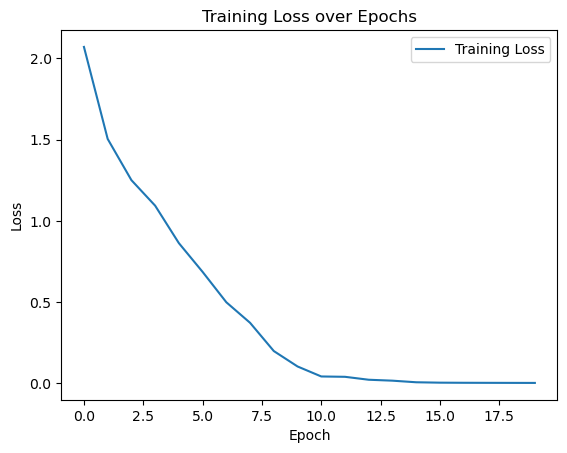

In [25]:
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)  # Увеличение размера пакета до 128

# Определение архитектуры сверточной нейронной сети
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 классов в STL10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели с визуализацией потерь
num_epochs = 20
total_step = len(trainloader)
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    losses.append(epoch_loss / total_step)
    print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss / total_step))

print("Обучение завершено!")

# Визуализация потерь
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [26]:
# Тестирование модели
model.eval()  # Установка модели в режим оценки
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: {}%'.format(100 * correct / total))

Accuracy on the test images: 57.2375%


Epoch [1/30], Step [10/40], Loss: 2.2277
Epoch [1/30], Step [20/40], Loss: 1.8858
Epoch [1/30], Step [30/40], Loss: 1.7969
Epoch [1/30], Step [40/40], Loss: 1.7852
Epoch [1/30], Average Loss: 1.9899
Epoch [2/30], Step [10/40], Loss: 1.7347
Epoch [2/30], Step [20/40], Loss: 1.6863
Epoch [2/30], Step [30/40], Loss: 1.5227
Epoch [2/30], Step [40/40], Loss: 1.7005
Epoch [2/30], Average Loss: 1.6673
Epoch [3/30], Step [10/40], Loss: 1.4836
Epoch [3/30], Step [20/40], Loss: 1.5282
Epoch [3/30], Step [30/40], Loss: 1.3338
Epoch [3/30], Step [40/40], Loss: 1.1309
Epoch [3/30], Average Loss: 1.4317
Epoch [4/30], Step [10/40], Loss: 1.4237
Epoch [4/30], Step [20/40], Loss: 1.3770
Epoch [4/30], Step [30/40], Loss: 1.2925
Epoch [4/30], Step [40/40], Loss: 1.5439
Epoch [4/30], Average Loss: 1.2740
Epoch [5/30], Step [10/40], Loss: 1.2155
Epoch [5/30], Step [20/40], Loss: 1.1614
Epoch [5/30], Step [30/40], Loss: 1.1063
Epoch [5/30], Step [40/40], Loss: 0.7865
Epoch [5/30], Average Loss: 1.1030
Epoch

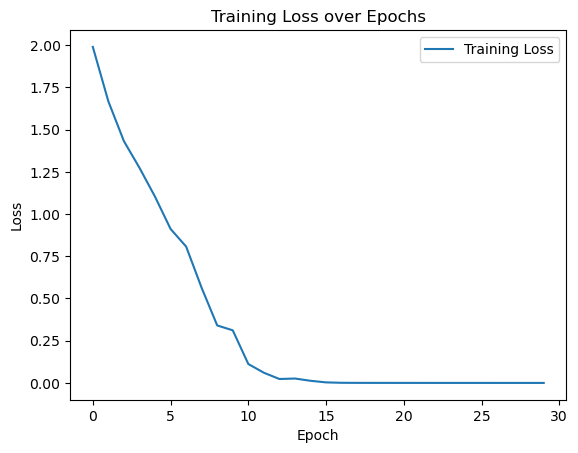

In [28]:
# Определение архитектуры сверточной нейронной сети с увеличенными параметрами
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 12 * 12, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)  # 10 классов в STL10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели с визуализацией потерь
num_epochs = 30  # Увеличение количества эпох до 30
total_step = len(trainloader)
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    losses.append(epoch_loss / total_step)
    print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss / total_step))

print("Обучение завершено!")

# Визуализация потерь
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [29]:
# Тестирование модели
model.eval()  # Установка модели в режим оценки
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: {}%'.format(100 * correct / total))

Accuracy on the test images: 60.0375%
